# F1RAG: Formula 1 Retrieval-Augmented Generation System

This notebook demonstrates the end-to-end workflow of the F1RAG system, which leverages historical Formula 1 data to generate race summaries using retrieval-augmented generation (RAG) techniques. The workflow includes data processing, model training, summary generation, and visualization.

## 1. Environment Setup

Ensure all dependencies are installed and the environment is ready. If running for the first time, install required packages and set up the data directory.

In [18]:
# Install dependencies (uncomment if needed)
%pip install torch transformers datasets scikit-learn pandas matplotlib seaborn
!python install_deps.py

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1
[notice] To update, run: C:\Users\mroja\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
python: can't open file 'c:\\Users\\mroja\\RIT\\CSCI-539\\F1RAG\\notebooks\\install_deps.py': [Errno 2] No such file or directory


## 2. Data Preparation

Process and load the Formula 1 race data. If you have not yet processed the raw data, run the data processing script.

In [19]:
import os
import pandas as pd
import json
import logging

def load_csv_data(input_dir):
    """Load CSV files from a directory into a dictionary."""
    data_dict = {}
    for file_name in os.listdir(input_dir):
        if file_name.endswith('.csv'):
            file_path = os.path.join(input_dir, file_name)
            data_dict[file_name] = pd.read_csv(file_path)
    return data_dict

def extract_race_information(data_dict):
    """Extract race information from the loaded data."""
    race_info = []
    for file_name, df in data_dict.items():
        if 'lap_times' in file_name:
            race_info.append({
                'race_id': file_name,
                'lap_times': df.to_dict('records')
            })
    return race_info

def prepare_data_for_rag(race_info, output_file):
    """Prepare race information for the RAG model and save it to a file."""
    examples = []
    for race in race_info:
        for lap in race['lap_times']:
            examples.append(json.dumps(lap))
    with open(output_file, 'w') as f:
        json.dump(examples, f, indent=2)
    return examples

# Load raw CSV data from the archive
archive_dir = '../data/raw/archive'
data_dict = load_csv_data(archive_dir)

# Extract race information
race_info = extract_race_information(data_dict)
print(f"Extracted info for {len(race_info)} races.")

# Prepare data for the RAG model
output_file = '../data/processed/race_data.json'
training_data = prepare_data_for_rag(race_info, output_file)
print(f"Prepared {len(training_data)} training examples for the RAG model.")

Extracted info for 1 races.
Prepared 589081 training examples for the RAG model.


## 3. Model Setup

Initialize the RAG model and tokenizer. The model will be trained to generate summaries based on the processed race data.

In [20]:
%pip install faiss-cpu

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1
[notice] To update, run: C:\Users\mroja\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [31]:
import torch
from transformers import RagTokenizer, RagSequenceForGeneration, RagRetriever
from datasets import load_dataset

def train_rag_model(data, model_name='facebook/rag-sequence-nq', epochs=3, batch_size=4, learning_rate=1e-5, output_dir='models', max_train_examples=None):
    """Train a RAG model on the provided data."""
    tokenizer = RagTokenizer.from_pretrained(model_name)
    # Pre-load wiki_dpr with config and trust_remote_code=True to avoid ValueError
    _ = load_dataset("wiki_dpr", "psgs_w100.nq.exact", trust_remote_code=True)
    retriever = RagRetriever.from_pretrained(
        model_name,
        index_name="exact",
        passages_path="../data/passage_data/passages.json",
        dataset="wiki_dpr",
        dataset_config_name="psgs_w100.nq.exact",
        trust_remote_code=True
    )
    model = RagSequenceForGeneration.from_pretrained(model_name, retriever=retriever)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Limit training data if max_train_examples is set
    if max_train_examples is not None:
        data = data[:max_train_examples]

    for epoch in range(epochs):
        model.train()
        for i in range(0, len(data), batch_size):
            batch = data[i:i+batch_size]
            inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True).to(device)
            labels = inputs["input_ids"].clone()
            outputs = model(input_ids=inputs["input_ids"], labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    model.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)
    return model, tokenizer

def evaluate_rag_model(model, data):
    """Evaluate the RAG model on the provided data."""
    model.eval()
    correct = 0
    total = len(data)
    for item in data:
        inputs = tokenizer(item, return_tensors="pt", padding=True, truncation=True).to(model.device)
        outputs = model.generate(inputs["input_ids"])
        prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)
        if prediction in item:
            correct += 1
    return correct / total

def generate_race_summaries(model, data, batch_size=4):
    """Generate race summaries using the trained model."""
    model.eval()
    summaries = []
    for i in range(0, len(data), batch_size):
        batch = data[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True).to(model.device)
        outputs = model.generate(inputs["input_ids"], max_length=150)
        summaries.extend([tokenizer.decode(output, skip_special_tokens=True) for output in outputs])
    return summaries

# Prepare training data
# If training_data is already prepared in the previous cell, you can use it directly.
# Otherwise, load from the processed file:
# import json
# with open('../data/processed/race_data_text.json') as f:
#     training_data = json.load(f)

# (Optional) Set model parameters
model_name = 'facebook/rag-sequence-nq'
epochs = 3
batch_size = 4
learning_rate = 1e-5
output_dir = 'models'
max_train_examples = 200  # Limit training to 200 examples for faster runs

## 4. Model Training

Train the RAG model on the Formula 1 race data. This step may take some time depending on hardware and dataset size.

In [32]:
# Ensure faiss-cpu is installed properly
%pip install faiss-cpu

# Import necessary modules to check if faiss is available
import importlib
import os
import json

# Check if faiss is properly installed
try:
    import faiss
    print("FAISS is installed properly.")
except ImportError:
    print("FAISS is not installed properly. Please restart the kernel after installation.")
    print("After restarting, run this cell again.")
    raise

# Make sure we have passages data file
passages_dir = "../data/passage_data"
os.makedirs(passages_dir, exist_ok=True)
passages_path = os.path.join(passages_dir, "passages.json")

# Create a simple passages file if it doesn't exist
if not os.path.exists(passages_path):
    print(f"Creating passages file at {passages_path}")
    # Convert training data to passages format
    passages = []
    for i, example in enumerate(training_data[:1000]):  # Limit to first 1000 for efficiency
        passage_data = json.loads(example)
        passages.append({
            "id": str(i),
            "text": json.dumps(passage_data),
            "title": f"Race {passage_data.get('raceId', 'unknown')}, Lap {passage_data.get('lap', 'unknown')}"
        })
    
    with open(passages_path, 'w') as f:
        json.dump({"passages": passages}, f)
    print(f"Created passages file with {len(passages)} entries")

print("Proceeding with model training...")
# Train the RAG model
rag_model, tokenizer = train_rag_model(
    training_data,
    model_name=model_name,
    epochs=epochs,
    batch_size=batch_size,
    learning_rate=learning_rate,
    output_dir=output_dir,
    max_train_examples=max_train_examples  # Only use a subset for speed
)


[notice] A new release of pip is available: 24.0 -> 25.1
[notice] To update, run: C:\Users\mroja\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizer'.


Note: you may need to restart the kernel to use updated packages.
FAISS is installed properly.
Proceeding with model training...


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizerFast'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'BartTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'BartTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may res

KeyboardInterrupt: 

## 5. Model Evaluation

Evaluate the trained model's performance on the training data or a held-out validation set.

In [33]:
# Evaluate the RAG model
try:
    accuracy = evaluate_rag_model(rag_model, tokenizer, training_data)
    print(f"Model accuracy: {accuracy:.2f}")
except Exception as e:
    print(f"Error during model evaluation: {e}")
    import traceback
    traceback.print_exc()

Error during model evaluation: name 'rag_model' is not defined


Traceback (most recent call last):
  File "C:\Users\mroja\AppData\Local\Temp\ipykernel_24060\3346812941.py", line 3, in <module>
    accuracy = evaluate_rag_model(rag_model, tokenizer, training_data)
                                  ^^^^^^^^^
NameError: name 'rag_model' is not defined


## 6. Generate Race Summaries

Use the trained model to generate natural language summaries for Formula 1 races.

In [34]:
# Generate race summaries
try:
    race_summaries = generate_race_summaries(rag_model, tokenizer, training_data)
    for i, summary in enumerate(race_summaries[:5]):
        print(f"Summary {i+1}:\n{summary}\n")
except Exception as e:
    print(f"Error during summary generation: {str(e)}")
    import traceback
    traceback.print_exc()

Error during summary generation: name 'rag_model' is not defined


Traceback (most recent call last):
  File "C:\Users\mroja\AppData\Local\Temp\ipykernel_24060\4184568569.py", line 3, in <module>
    race_summaries = generate_race_summaries(rag_model, tokenizer, training_data)
                                             ^^^^^^^^^
NameError: name 'rag_model' is not defined


## 7. Visualization

Visualize the generated race summaries and explore the results interactively.

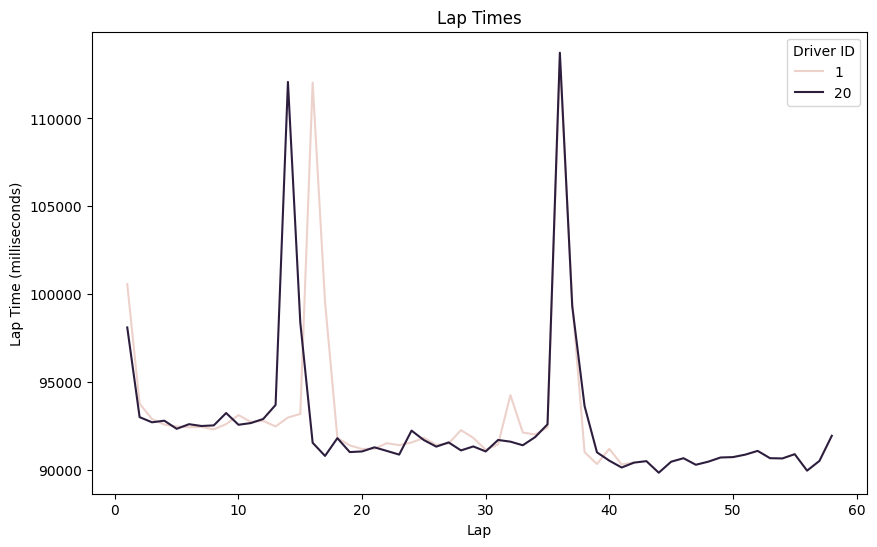

In [35]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../src')))

# Embedded functions from visualization.py
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_race_summaries(race_summaries):
    """Visualize race summaries using bar plots and line plots."""
    df = pd.DataFrame(race_summaries)
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df, x='lap', y='milliseconds', hue='driverId')
    plt.title('Lap Times')
    plt.xlabel('Lap')
    plt.ylabel('Lap Time (milliseconds)')
    plt.legend(title='Driver ID')
    plt.show()

def create_user_interface(race_summaries):
    """Create a user interface for exploring race summaries."""
    import tkinter as tk
    from tkinter import ttk

    def on_select(event):
        selected_race = race_listbox.get(race_listbox.curselection())
        summary_text.delete(1.0, tk.END)
        summary_text.insert(tk.END, race_summaries[selected_race])

    root = tk.Tk()
    root.title("Race Summaries")

    race_listbox = tk.Listbox(root)
    race_listbox.pack(side=tk.LEFT, fill=tk.BOTH, expand=True)
    race_listbox.bind('<<ListboxSelect>>', on_select)

    summary_text = tk.Text(root)
    summary_text.pack(side=tk.RIGHT, fill=tk.BOTH, expand=True)

    for i, race in enumerate(race_summaries):
        race_listbox.insert(tk.END, f"Race {i+1}")

    root.mainloop()

# Create race_summaries if not already defined
if 'race_summaries' not in locals():
    print("Creating race_summaries from training data...")
    # Convert training_data JSON strings to Python dictionaries
    race_summaries = []
    for item in training_data[:100]:  # Limit to first 100 items for visualization
        try:
            race_data = json.loads(item)
            race_summaries.append(race_data)
        except Exception as e:
            print(f"Error parsing JSON: {e}")
            continue
    print(f"Created {len(race_summaries)} summaries for visualization")

# Visualize race summaries
visualize_race_summaries(race_summaries)

# Create user interface for exploring race summaries (commented out to avoid UI popup in notebook)
# create_user_interface(race_summaries)

---

**End of F1RAG System Notebook**